In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import site
site.addsitedir('../../../ARGUS')
from ARGUSUtils_Transforms import *

C:\Users\stephen.aylward\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
img_dir = "../../../Data/TrainingData/AR-UNet/BAMC-PTX*Sliding-Linear/"
ovr_dir = "../../../Data/TrainingData/AR-UNet/BAMC-PTX*Sliding-Annotations-Linear/"

all_images = sorted(glob(os.path.join(img_dir, '*.mha')))
all_labels = sorted(glob(os.path.join(ovr_dir, '*.interpolated-overlay.mha')))

num_images = len(all_images)
num_labels = len(all_labels)
print(num_images, num_labels)

train_images = all_images[:num_images-6]
train_labels = all_labels[:num_images-6]

val_images = all_images[num_images-6:]
val_labels = all_labels[num_images-6:]

train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(val_images, val_labels)]

58 58


In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[144,144,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(num_slices=48,
            axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.2, 
            min_zoom=1.0,
            max_zoom=1.2,
            keys=['image', 'label'],
            keep_size=True,
            mode=['trilinear', 'nearest']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[144,144,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(num_slices=48,
            axis=2,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


torch.Size([1, 1, 144, 144, 48])
torch.Size([144, 144, 48])
image shape: torch.Size([144, 144, 48]), label shape: torch.Size([144, 144, 48])


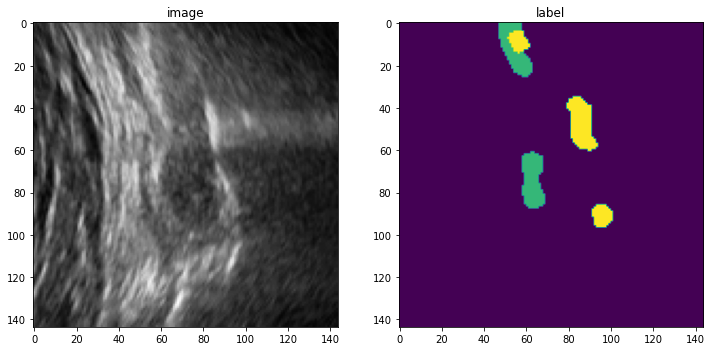

In [4]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 2])
plt.show()

In [5]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=0)
#train_ds = Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)


val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
#val_ds = Dataset(data=val_files, transform=val_transforms)
    
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)

Loading dataset: 100%|███████████████████████████| 6/6 [00:00<00:00,  7.15it/s]


In [6]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64),
    strides=(2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [7]:
max_epochs = 2000
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=4)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=4)])

root_dir = "."

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        print("Step =", step)
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (144, 144, 16)
                sw_batch_size = 1
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/2000
Step = 0
1/13, train_loss: 0.8798
Step = 1
2/13, train_loss: 0.8799
Step = 2
3/13, train_loss: 0.8743
Step = 3
4/13, train_loss: 0.8722
Step = 4
5/13, train_loss: 0.8752
Step = 5
6/13, train_loss: 0.8769
Step = 6
7/13, train_loss: 0.8797
Step = 7
8/13, train_loss: 0.8694
Step = 8
9/13, train_loss: 0.8713
Step = 9
10/13, train_loss: 0.8642
Step = 10
11/13, train_loss: 0.8659
Step = 11
12/13, train_loss: 0.8741
Step = 12
13/13, train_loss: 0.8685
epoch 1 average loss: 0.8732
----------
epoch 2/2000
Step = 0
1/13, train_loss: 0.8636
Step = 1
2/13, train_loss: 0.8623
Step = 2
3/13, train_loss: 0.8579
Step = 3
4/13, train_loss: 0.8580
Step = 4
5/13, train_loss: 0.8531
Step = 5
6/13, train_loss: 0.8557
Step = 6
7/13, train_loss: 0.8685
Step = 7
8/13, train_loss: 0.8564
Step = 8
9/13, train_loss: 0.8528
Step = 9
10/13, train_loss: 0.8569
Step = 10
11/13, train_loss: 0.8569
Step = 11
12/13, train_loss: 0.8478
Step = 12
13/13, train_loss: 0.8617
epoch 2 average loss: 0.8

12/13, train_loss: 0.7560
Step = 12
13/13, train_loss: 0.7548
epoch 15 average loss: 0.7577
----------
epoch 16/2000
Step = 0
1/13, train_loss: 0.7752
Step = 1
2/13, train_loss: 0.7686
Step = 2
3/13, train_loss: 0.7564
Step = 3
4/13, train_loss: 0.7320
Step = 4
5/13, train_loss: 0.7593
Step = 5
6/13, train_loss: 0.7327
Step = 6
7/13, train_loss: 0.7701
Step = 7
8/13, train_loss: 0.7517
Step = 8
9/13, train_loss: 0.7509
Step = 9
10/13, train_loss: 0.7458
Step = 10
11/13, train_loss: 0.7506
Step = 11
12/13, train_loss: 0.7412
Step = 12
13/13, train_loss: 0.7487
epoch 16 average loss: 0.7526
saved new best metric model
current epoch: 16 current mean dice: 0.3548
best mean dice: 0.3548 at epoch: 16
----------
epoch 17/2000
Step = 0
1/13, train_loss: 0.7399
Step = 1
2/13, train_loss: 0.7470
Step = 2
3/13, train_loss: 0.7496
Step = 3
4/13, train_loss: 0.7379
Step = 4
5/13, train_loss: 0.7570
Step = 5
6/13, train_loss: 0.7718
Step = 6
7/13, train_loss: 0.7455
Step = 7
8/13, train_loss: 0.7043

12/13, train_loss: 0.6863
Step = 12
13/13, train_loss: 0.6490
epoch 30 average loss: 0.6678
current epoch: 30 current mean dice: 0.3772
best mean dice: 0.4068 at epoch: 24
----------
epoch 31/2000
Step = 0
1/13, train_loss: 0.7005
Step = 1
2/13, train_loss: 0.6472
Step = 2
3/13, train_loss: 0.7124
Step = 3
4/13, train_loss: 0.6222
Step = 4
5/13, train_loss: 0.6926
Step = 5
6/13, train_loss: 0.6849
Step = 6
7/13, train_loss: 0.6402
Step = 7
8/13, train_loss: 0.5920
Step = 8
9/13, train_loss: 0.7004
Step = 9
10/13, train_loss: 0.6745
Step = 10
11/13, train_loss: 0.6991
Step = 11
12/13, train_loss: 0.5990
Step = 12
13/13, train_loss: 0.6887
epoch 31 average loss: 0.6657
----------
epoch 32/2000
Step = 0
1/13, train_loss: 0.5882
Step = 1
2/13, train_loss: 0.6839
Step = 2
3/13, train_loss: 0.6526
Step = 3
4/13, train_loss: 0.6650
Step = 4
5/13, train_loss: 0.6645
Step = 5
6/13, train_loss: 0.6949
Step = 6
7/13, train_loss: 0.6114
Step = 7
8/13, train_loss: 0.6114
Step = 8
9/13, train_loss: 

12/13, train_loss: 0.5907
Step = 12
13/13, train_loss: 0.6122
epoch 45 average loss: 0.6097
----------
epoch 46/2000
Step = 0
1/13, train_loss: 0.5767
Step = 1
2/13, train_loss: 0.5866
Step = 2
3/13, train_loss: 0.6191
Step = 3
4/13, train_loss: 0.5842
Step = 4
5/13, train_loss: 0.5443
Step = 5
6/13, train_loss: 0.6678
Step = 6
7/13, train_loss: 0.6169
Step = 7
8/13, train_loss: 0.6588
Step = 8
9/13, train_loss: 0.5707
Step = 9
10/13, train_loss: 0.6159
Step = 10
11/13, train_loss: 0.6498
Step = 11
12/13, train_loss: 0.5407
Step = 12
13/13, train_loss: 0.5794
epoch 46 average loss: 0.6008
current epoch: 46 current mean dice: 0.3827
best mean dice: 0.4316 at epoch: 32
----------
epoch 47/2000
Step = 0
1/13, train_loss: 0.5931
Step = 1
2/13, train_loss: 0.5601
Step = 2
3/13, train_loss: 0.5867
Step = 3
4/13, train_loss: 0.6407
Step = 4
5/13, train_loss: 0.5564
Step = 5
6/13, train_loss: 0.6121
Step = 6
7/13, train_loss: 0.6121
Step = 7
8/13, train_loss: 0.6378
Step = 8
9/13, train_loss: 

current epoch: 60 current mean dice: 0.1429
best mean dice: 0.4316 at epoch: 32
----------
epoch 61/2000
Step = 0
1/13, train_loss: 0.5054
Step = 1
2/13, train_loss: 0.5264
Step = 2
3/13, train_loss: 0.4996
Step = 3
4/13, train_loss: 0.4935
Step = 4
5/13, train_loss: 0.6027
Step = 5
6/13, train_loss: 0.5531
Step = 6
7/13, train_loss: 0.5679
Step = 7
8/13, train_loss: 0.5276
Step = 8
9/13, train_loss: 0.5449
Step = 9
10/13, train_loss: 0.5072
Step = 10
11/13, train_loss: 0.5610
Step = 11
12/13, train_loss: 0.4702
Step = 12
13/13, train_loss: 0.5061
epoch 61 average loss: 0.5281
----------
epoch 62/2000
Step = 0
1/13, train_loss: 0.4942
Step = 1
2/13, train_loss: 0.5288
Step = 2
3/13, train_loss: 0.5146
Step = 3
4/13, train_loss: 0.4971
Step = 4
5/13, train_loss: 0.5424
Step = 5
6/13, train_loss: 0.5271
Step = 6
7/13, train_loss: 0.5674
Step = 7
8/13, train_loss: 0.5190
Step = 8
9/13, train_loss: 0.4948
Step = 9
10/13, train_loss: 0.5418
Step = 10
11/13, train_loss: 0.5144
Step = 11
12/1

1/13, train_loss: 0.4675
Step = 1
2/13, train_loss: 0.4733
Step = 2
3/13, train_loss: 0.4762
Step = 3
4/13, train_loss: 0.4969
Step = 4
5/13, train_loss: 0.5005
Step = 5
6/13, train_loss: 0.5937
Step = 6
7/13, train_loss: 0.4625
Step = 7
8/13, train_loss: 0.4888
Step = 8
9/13, train_loss: 0.5108
Step = 9
10/13, train_loss: 0.5018
Step = 10
11/13, train_loss: 0.4550
Step = 11
12/13, train_loss: 0.4491
Step = 12
13/13, train_loss: 0.5058
epoch 76 average loss: 0.4909
current epoch: 76 current mean dice: 0.3583
best mean dice: 0.4596 at epoch: 74
----------
epoch 77/2000
Step = 0
1/13, train_loss: 0.4568
Step = 1
2/13, train_loss: 0.4728
Step = 2
3/13, train_loss: 0.4644
Step = 3
4/13, train_loss: 0.4702
Step = 4
5/13, train_loss: 0.4636
Step = 5
6/13, train_loss: 0.5135
Step = 6
7/13, train_loss: 0.5201
Step = 7
8/13, train_loss: 0.5190
Step = 8
9/13, train_loss: 0.5031
Step = 9
10/13, train_loss: 0.5225
Step = 10
11/13, train_loss: 0.4395
Step = 11
12/13, train_loss: 0.4556
Step = 12
13

1/13, train_loss: 0.5272
Step = 1
2/13, train_loss: 0.5051
Step = 2
3/13, train_loss: 0.4813
Step = 3
4/13, train_loss: 0.4868
Step = 4
5/13, train_loss: 0.4661
Step = 5
6/13, train_loss: 0.4405
Step = 6
7/13, train_loss: 0.4142
Step = 7
8/13, train_loss: 0.4698
Step = 8
9/13, train_loss: 0.4134
Step = 9
10/13, train_loss: 0.4324
Step = 10
11/13, train_loss: 0.4568
Step = 11
12/13, train_loss: 0.4644
Step = 12
13/13, train_loss: 0.4685
epoch 91 average loss: 0.4636
----------
epoch 92/2000
Step = 0
1/13, train_loss: 0.4921
Step = 1
2/13, train_loss: 0.4694
Step = 2
3/13, train_loss: 0.4585
Step = 3
4/13, train_loss: 0.4199
Step = 4
5/13, train_loss: 0.4529
Step = 5
6/13, train_loss: 0.4187
Step = 6
7/13, train_loss: 0.4961
Step = 7
8/13, train_loss: 0.4577
Step = 8
9/13, train_loss: 0.4515
Step = 9
10/13, train_loss: 0.4816
Step = 10
11/13, train_loss: 0.4721
Step = 11
12/13, train_loss: 0.5021
Step = 12
13/13, train_loss: 0.4439
epoch 92 average loss: 0.4628
current epoch: 92 current 

Step = 2
3/13, train_loss: 0.4369
Step = 3
4/13, train_loss: 0.4376
Step = 4
5/13, train_loss: 0.4577
Step = 5
6/13, train_loss: 0.4358
Step = 6
7/13, train_loss: 0.4568
Step = 7
8/13, train_loss: 0.4592
Step = 8
9/13, train_loss: 0.4220
Step = 9
10/13, train_loss: 0.4406
Step = 10
11/13, train_loss: 0.5068
Step = 11
12/13, train_loss: 0.4858
Step = 12
13/13, train_loss: 0.4430
epoch 106 average loss: 0.4561
current epoch: 106 current mean dice: 0.3842
best mean dice: 0.4596 at epoch: 74
----------
epoch 107/2000
Step = 0
1/13, train_loss: 0.4138
Step = 1
2/13, train_loss: 0.4143
Step = 2
3/13, train_loss: 0.4645
Step = 3
4/13, train_loss: 0.4723
Step = 4
5/13, train_loss: 0.4511
Step = 5
6/13, train_loss: 0.4642
Step = 6
7/13, train_loss: 0.4524
Step = 7
8/13, train_loss: 0.4103
Step = 8
9/13, train_loss: 0.4561
Step = 9
10/13, train_loss: 0.4402
Step = 10
11/13, train_loss: 0.4265
Step = 11
12/13, train_loss: 0.4669
Step = 12
13/13, train_loss: 0.4924
epoch 107 average loss: 0.4481
-

KeyboardInterrupt: 

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

## Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (144, 144, 16)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 10], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 10])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 10])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=0)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=True, num_classes=4),
    AsDiscreted(keys="label", to_onehot=True, num_classes=4),
])

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (144, 144, 16)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)